# Tweet Sentiment Classification with Fine-Tuned GPT-2
*A transformer-based solution for decoding mood on social media*

## Import Libraries

Libraries required for data processing and modeling are imported.

This project runs in Google Colab to make use of the free GPU support. Start by mounting Google Drive to access the project files. If this is your first time running the project, clone the repository. Otherwise, pull the latest changes to stay up to date. Once that’s done, run the setup script to install any dependencies and make sure the environment is ready to go.

In [1]:
# Mount Drive on colab manually
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# If the repo doesn't exist in Google Drive, clone it
# !git clone https://github.com/herrerovir/gpt2-tweet-sentiment

# If the repo does exist:
%cd /content/drive/MyDrive/Colab_Projects/gpt2-tweet-sentiment
!git pull

/content/drive/MyDrive/Colab_Projects/gpt2-tweet-sentiment
Updating 04fcd86..d375441
error: Your local changes to the following files would be overwritten by merge:
	notebooks/gpt2-finetune-tweet-sentiment.ipynb
Please commit your changes or stash them before you merge.
Aborting


In [3]:
# Import config file
import config
config.setup(subdir = "notebooks")
from config import *

Working directory set to: /content/drive/MyDrive/Colab_Projects/gpt2-tweet-sentiment/notebooks


In [4]:
# Install dependencies
!pip install evaluate

# Utilities
import re
from collections import Counter
import numpy as np
import pandas as pd
import torch

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn metrics
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

# Hugging Face datasets and transformers
from datasets import load_from_disk, DatasetDict
from transformers import (
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    GPT2Config,
    GPT2ForSequenceClassification,
    GPT2Tokenizer,
    TextClassificationPipeline,
    Trainer,
    TrainingArguments,
    set_seed
)

# Evaluation tools
import evaluate
from evaluate import load

# Set random seed for reproducibility
set_seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00


## Data Loading

This step loads a preprocessed dataset using Hugging Face’s load_from_disk method. The dataset is stored locally and includes different splits, such as training and validation, organized in a DatasetDict. Once loaded, it can be used directly for model training, evaluation, or inspection.

In [5]:
# Load preprocessed Hugging Face dataset
dataset: DatasetDict = load_from_disk(RAW_DIR / "HF-dataset-tweet-sentiment-extraction")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3534
    })
})

## Data Cleaning

This step removes nulls, duplicates, URLs, mentions, and extra spaces to reduce noise and improve model performance. It also checks label distribution to ensure classes are balanced before training.

In [6]:
# Show first entries of the dataset
print("First 5 entries from the training data:")
for i in range(5):
    print(f"\n{i+1}. {dataset['train'][i]['text']}")

First 5 entries from the training data:

1.  I`d have responded, if I were going

2.  Sooo SAD I will miss you here in San Diego!!!

3. my boss is bullying me...

4.  what interview! leave me alone

5.  Sons of ****, why couldn`t they put them on the releases we already bought


### Dataset split and sizes

Check the number of samples in each split to confirm the dataset is structured correctly and ready for use.

In [7]:
print("Dataset splits and sizes:")
for split in dataset:
    print(f"- {split}: {len(dataset[split])} samples")

Dataset splits and sizes:
- train: 27481 samples
- test: 3534 samples


### Null Values

Identify and handle missing data to prevent errors during training and ensure model reliability. Cleaning null values helps maintain data quality.

In [8]:
print("Null values in the dataset:")
for split in dataset:
    texts = dataset[split]["text"]
    empty_count = sum(1 for x in texts if x is None or (isinstance(x, str) and x.strip() == ""))
    print(f"- {split}: {empty_count} null values")


Null values in the dataset:
- train: 1 null values
- test: 0 null values


In [9]:
def is_valid(example):
    """
    Checks whether a text example is valid for further processing.

    An example is considered valid if:
    - The 'text' field is not None.
    - The 'text' field is not an empty string or whitespace-only.

    Parameters:
        example (dict): A single data sample, expected to have a 'text' key.

    Returns:
        bool: True if the example has a valid, non-empty 'text' field; False otherwise.
    """
    return example["text"] is not None and example["text"].strip() != ""

dataset = dataset.filter(is_valid)

In [10]:
print("Dataset splits sizes after removing null values:")
for split in dataset:
    print(f"- {split}: {len(dataset[split])} samples")

Dataset splits sizes after removing null values:
- train: 27480 samples
- test: 3534 samples


### Duplicate Values

Detect and remove duplicate entries to avoid bias and ensure the model trains on unique data points.

In [11]:
print("Duplicate values in the dataset:")
for split in dataset:
    texts = dataset[split]["text"]
    dupes = len(texts) - len(set(texts))
    print(f"- {split}: {dupes} duplicates")

Duplicate values in the dataset:
- train: 0 duplicates
- test: 0 duplicates


### Remove URLs, Mentions and White Spaces

Clean the text by removing URLs, user mentions, and extra white spaces to reduce noise and improve model focus on meaningful content.

In [12]:
def clean_tweet(text):
    """
    Cleans a tweet for sentiment classification:

    Steps performed:
    - Removes URLs (e.g., http://..., https://..., www...)
    - Removes user mentions (e.g., @username)
    - Removes extra whitespace (multiple spaces, leading/trailing spaces)

    Parameters:
        text (str): The tweet text to clean. Can be None.

    Returns:
        str: The cleaned tweet text. If input is None, returns an empty string.
    """
    if text is None:
        return ""

    # Remove URLs
    text = re.sub(r"http\S+|www\.\S+", "", text)

    # Remove mentions
    text = re.sub(r"@\w+", "", text)

    # Remove extra spaces and strip leading/trailing whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [13]:
def clean_example(example):
    example["text"] = clean_tweet(example["text"])
    return example

dataset = dataset.map(clean_example)

Check for duplicates again after cleaning to ensure no redundant data remains that could affect model performance.

In [14]:
print("Duplicate values in the dataset:")
for split in dataset:
    texts = dataset[split]["text"]
    dupes = len(texts) - len(set(texts))
    print(f"- {split}: {dupes} duplicates")

Duplicate values in the dataset:
- train: 45 duplicates
- test: 1 duplicates


In [15]:
for split in dataset:
    # Convert to pandas DataFrame
    df = dataset[split].to_pandas()
    # Drop duplicates
    df = df.drop_duplicates(subset = ["text"])
    # Convert back to Dataset
    dataset[split] = dataset[split].from_pandas(df)

### Label Distribution

Review the balance of labels to identify any class imbalances that could impact model training and evaluation. The dataset includes three labels: 0 for negative, 1 for neutral, and 2 for positive.

In [16]:
print("Dataset Label distribution:")
for split in dataset:
    labels = dataset[split]["label"]
    counts = Counter(labels)
    total = len(labels)

    print(f"\n{split.title()} Set:")
    for label, count in sorted(counts.items()):
        print(f"  Label {label}: {count} ({count/total*100:.2f}%)")

Dataset Label distribution:

Train Set:
  Label 0: 7773 (28.33%)
  Label 1: 11103 (40.47%)
  Label 2: 8559 (31.20%)

Test Set:
  Label 0: 1000 (28.30%)
  Label 1: 1430 (40.48%)
  Label 2: 1103 (31.22%)


The dataset has three labels: 0 (negative), 1 (neutral), and 2 (positive). The distribution across train and test sets is fairly balanced, with each class representing roughly 28% to 40% of the data. This balance reduces the risk of bias during model training.

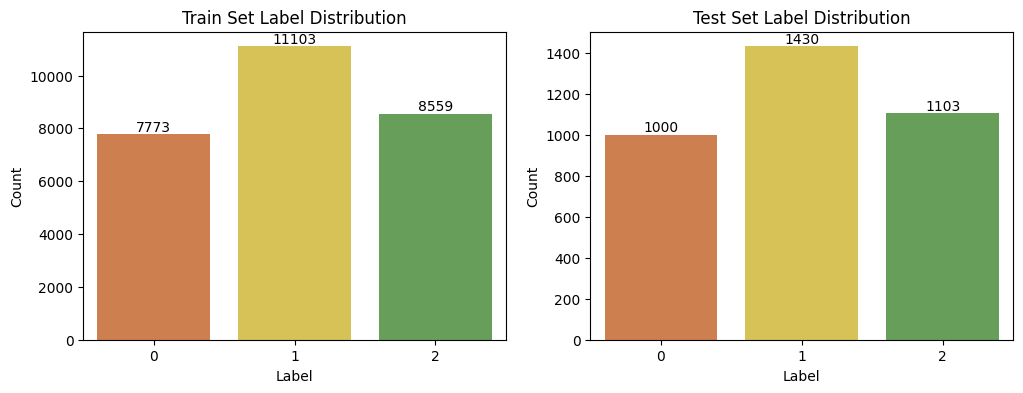

In [17]:
label_colors = {"0": "#e27a3b", "1": "#edd041", "2": "#60aa4f"}

# Plot label distribution for each split
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

for idx, split in enumerate(dataset):
    # Convert the split to a pandas DataFrame
    df = dataset[split].to_pandas()
    # Calculate label distribution
    label_counts = df["label"].value_counts().sort_index()

    # Prepare data for plotting
    plot_df = pd.DataFrame({
        "label": label_counts.index.astype(str),
        "count": label_counts.values
    })

    # Plot using hue and custom palette
    ax = axes[idx]
    sns.barplot(data = plot_df, x = "label", y = "count", hue = "label", palette = label_colors, ax = axes[idx], legend = False)

    # Add value labels on top of each bar
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f"{int(height)}", (p.get_x() + p.get_width() / 2, height), ha = "center", va = "bottom", fontsize = 10)

    axes[idx].set_title(f"{split.title()} Set Label Distribution")
    axes[idx].set_xlabel("Label")
    axes[idx].set_ylabel("Count")

In [ ]:
# Save the cleaned dataset
dataset.save_to_disk(PROCESSED_DIR / "HF-dataset-tweet-sentiment-extraction-cleaned")

Saving the dataset (0/1 shards):   0%|          | 0/27435 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3533 [00:00<?, ? examples/s]

## Tokenization

The GPT-2 tokenizer is initialized to convert text into tokens the model can process. Since GPT-2 doesn’t have a pad token, the end-of-sequence token is used as a substitute. The dataset is tokenized with truncation enabled to limit sequence length, but padding is not added here because batching with padding is handled later during training for efficiency.

Next, the label column is renamed to labels to match what the transformers library expects. Finally, the dataset format is set to PyTorch tensors, keeping only the necessary columns: input_ids, attention_mask, and labels.

In [ ]:
# Initialize tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token # workaround since GPT-2 has no pad token

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation = True) # only truncation, no padding

tokenized_dataset = dataset.map(tokenize_function, batched = True)

# Retain the label but first rename the column, transformers expect a column named labels
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

# Set format for PyTorch tensors and keep only necessary columns
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Map:   0%|          | 0/27435 [00:00<?, ? examples/s]

Map:   0%|          | 0/3533 [00:00<?, ? examples/s]

In [ ]:
train = tokenized_dataset["train"]
test = tokenized_dataset["test"]

print(f"Tokenized train set size: {len(train)}")
print(f"Tokenized test set size: {len(test)}")

Tokenized train set size: 27435
Tokenized test set size: 3533


## Data Collator

The `DataCollatorWithPadding` is used to dynamically pad input sequences within each batch during training. This ensures all sequences in a batch have the same length without padding the entire dataset upfront, improving training efficiency.

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)